# 📂 Cell 1: Install & Import Required Libraries


In [ ]:
# Install Required Libraries
%pip install opencv-python scikit-learn matplotlib seaborn joblib yt-dlp selenium streamlit pyngrok

# Install Chrome and ChromeDriver for Selenium
%apt-get update
%apt install -y chromium-chromedriver
%cp /usr/lib/chromium-browser/chromedriver /usr/bin


In [ ]:

# Import Libraries
import cv2
import zipfile
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from google.colab.patches import cv2_imshow
import yt_dlp
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import urllib.request
import time
import streamlit as st
from pyngrok import ngrok

In [ ]:
# Define Emotion Labels
emotion_labels = {
    0: 'anger',
    1: 'contempt',
    2: 'disgust',
    3: 'fear',
    4: 'happy',
    5: 'sadness',
    6: 'surprise'
}

# Mount Google Drive (Optional, for persisting model file)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#bonus first task : webscraping

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import StaleElementReferenceException, TimeoutException, NoSuchElementException
import urllib.request
import time
import os
from PIL import Image
import requests
import mimetypes

def setup_selenium():
    """Set up Selenium WebDriver for Google Chrome."""
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36')
    driver = webdriver.Chrome(options=chrome_options)
    driver.set_page_load_timeout(60)  # Increased timeout for page load
    return driver

def validate_image(url, output_path):
    """Validate that the downloaded image is a valid image file."""
    try:
        # Check content type
        response = requests.head(url, timeout=10, allow_redirects=True)
        content_type = response.headers.get('content-type', '').lower()
        if not content_type.startswith('image/') or 'svg' in content_type:
            print(f" Invalid content type for {url}: {content_type}")
            return False
        # Download image
        response = requests.get(url, stream=True, timeout=15)
        if response.status_code != 200:
            print(f" HTTP error for {url}: {response.status_code} - {response.reason}")
            return False
        # Determine file extension
        extension = mimetypes.guess_extension(content_type) or '.jpg'
        if extension not in ['.jpg', '.jpeg', '.png', '.webp']:
            print(f"Unsupported image format for {url}: {extension}")
            return False
        output_path = os.path.splitext(output_path)[0] + extension
        # Save and verify
        with open(output_path, 'wb') as f:
            f.write(response.content)
        img = Image.open(output_path)
        img.verify()  # Verify image integrity
        img.close()
        return True
    except Exception as e:
        print(f" Image validation failed for {url}: {str(e)}")
        if os.path.exists(output_path):
            os.remove(output_path)  # Remove invalid file
        return False

def count_valid_images(folder):
    """Count valid images in the specified folder."""
    if not os.path.exists(folder):
        return 0
    count = 0
    for file in os.listdir(folder):
        try:
            img_path = os.path.join(folder, file)
            img = Image.open(img_path)
            img.verify()
            img.close()
            count += 1
        except Exception:
            continue
    return count

def scrape_images_google(query, num_images, output_dir):
    """Scrape images from Google Images."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    driver = setup_selenium()
    url = f"https://www.google.com/search?q={query}&tbm=isch"
    try:
        driver.get(url)
        time.sleep(15)  # Increased for initial load
    except Exception as e:
        print(f" Google page load failed for {query}: {str(e)}")
        driver.quit()
        return 0

    # Scroll to load more images
    for _ in range(30):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(8)

    # Find image elements
    count = 0
    skipped = 0
    while count < num_images:
        try:
            images = driver.find_elements(By.CSS_SELECTOR, "img.Q4LuWd, img.rg_i, img[src], img[data-src], img[data-iurl]")
            if not images:
                print(f" No images found for {query} on Google")
                break
            for img in images:
                if count >= num_images:
                    break
                try:
                    # Try direct src, data-src, or data-iurl
                    src = img.get_attribute('src') or img.get_attribute('data-src') or img.get_attribute('data-iurl')
                    if src and src.startswith('http') and 'images' in src.lower() and 'google' in src.lower() and '.svg' not in src.lower():
                        output_path = os.path.join(output_dir, f"{query}_google_{count}.jpg")
                        if validate_image(src, output_path):
                            count += 1
                            print(f" Downloaded and validated {query}_google_{count}.jpg")
                        else:
                            skipped += 1
                        time.sleep(1)  # Avoid rate limiting
                        continue
                    # Click thumbnail to load full image
                    try:
                        WebDriverWait(driver, 30).until(EC.element_to_be_clickable(img))
                        ActionChains(driver).move_to_element(img).click().perform()
                        time.sleep(6)
                        full_img = driver.find_elements(By.CSS_SELECTOR, "img.n3VNCb, img.sFlh5c, img[src], img[data-src]")
                        for fi in full_img:
                            src = fi.get_attribute('src') or fi.get_attribute('data-src')
                            if src and src.startswith('http') and 'images' in src.lower() and '.svg' not in src.lower():
                                output_path = os.path.join(output_dir, f"{query}_google_{count}.jpg")
                                if validate_image(src, output_path):
                                    count += 1
                                    print(f" Downloaded and validated {query}_google_{count}.jpg")
                                    break
                                else:
                                    skipped += 1
                        driver.execute_script("window.history.back()")
                        time.sleep(4)
                    except (TimeoutException, StaleElementReferenceException, NoSuchElementException) as e:
                        print(f" Google WebDriverWait for {query}_{count}: {str(e)}")
                        skipped += 1
                except Exception as e:
                    print(f" Google attempt for {query}_{count}: {str(e)}")
                    skipped += 1
            else:
                break
        except Exception as e:
            print(f" Google image fetch error for {query}: {str(e)}")
            break

    driver.quit()
    print(f"Scraped {count} Google images for {query}, skipped {skipped} images")
    return count

def scrape_images_bing(query, num_images, output_dir):
    """Scrape images from Bing Images."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    driver = setup_selenium()
    url = f"https://www.bing.com/images/search?q={query}"
    try:
        driver.get(url)
        time.sleep(15)
    except Exception as e:
        print(f" Bing page load failed for {query}: {str(e)}")
        driver.quit()
        return 0

    # Scroll to load more images
    for _ in range(30):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(8)

    # Find image elements
    count = 0
    skipped = 0
    while count < num_images:
        try:
            images = driver.find_elements(By.CSS_SELECTOR, "a.iusc img, div.iusc img, img.mimg, img[src], img[data-src], div.imgpt img")
            if not images:
                print(f" No images found for {query} on Bing")
                break
            for img in images:
                if count >= num_images:
                    break
                try:
                    # Try direct src or data-src
                    src = img.get_attribute('src') or img.get_attribute('data-src')
                    if src and src.startswith('http') and ('mmbing' in src.lower() or 'bing' in src.lower()) and '.svg' not in src.lower():
                        output_path = os.path.join(output_dir, f"{query}_bing_{count}.jpg")
                        if validate_image(src, output_path):
                            count += 1
                            print(f" Downloaded and validated {query}_bing_{count}.jpg")
                        else:
                            skipped += 1
                        time.sleep(1)  # Avoid rate limiting
                        continue
                    # Click thumbnail if no valid src
                    try:
                        WebDriverWait(driver, 30).until(EC.element_to_be_clickable(img))
                        ActionChains(driver).move_to_element(img).click().perform()
                        time.sleep(6)
                        full_img = driver.find_elements(By.CSS_SELECTOR, "img.mainImage, img[src], img[data-src], div.iusc img")
                        for fi in full_img:
                            src = fi.get_attribute('src') or fi.get_attribute('data-src')
                            if src and src.startswith('http') and '.svg' not in src.lower():
                                output_path = os.path.join(output_dir, f"{query}_bing_{count}.jpg")
                                if validate_image(src, output_path):
                                    count += 1
                                    print(f" Downloaded and validated {query}_bing_{count}.jpg")
                                    break
                                else:
                                    skipped += 1
                        driver.execute_script("window.history.back()")
                        time.sleep(4)
                    except (TimeoutException, StaleElementReferenceException, NoSuchElementException) as e:
                        print(f" Bing WebDriverWait for {query}_{count}: {str(e)}")
                        skipped += 1
                except Exception as e:
                    print(f" Bing attempt for {query}_{count}: {str(e)}")
                    skipped += 1
            else:
                break
        except Exception as e:
            print(f" Bing image fetch error for {query}: {str(e)}")
            break

    driver.quit()
    print(f"Scraped {count} Bing images for {query}, skipped {skipped} images")
    return count

# Scrape images from Bing (primary) and Google (fallback) to reach 50 images per emotion
custom_dataset_path = '/content/custom_emotions'
for emotion in emotion_labels.values():
    output_dir = os.path.join(custom_dataset_path, emotion)
    # Check if 50 valid images already exist
    existing_images = count_valid_images(output_dir)
    if existing_images >= 50:
        print(f" Skipping {emotion}: {existing_images} valid images already exist")
        continue

    # Try multiple query variations to improve results
    queries = [f"{emotion} facial expression", f"{emotion} face", f"{emotion} emotion"]
    total_count = existing_images
    for query in queries:
        if total_count >= 50:
            break
        remaining = 50 - total_count
        # Try Bing first
        bing_count = scrape_images_bing(query, remaining, output_dir)
        total_count += bing_count
        # If still < 50, use Google
        if total_count < 50:
            remaining = 50 - total_count
            google_count = scrape_images_google(query, remaining, output_dir)
            total_count += google_count

    print(f"Total for {emotion}: {total_count} images")

Streaming output truncated to the last 5000 lines.
Stacktrace:
#0 0x5c2913e9b7fa <unknown>
#1 0x5c291393fe90 <unknown>
#2 0x5c291395352b <unknown>
#3 0x5c29139522f2 <unknown>
#4 0x5c2913947449 <unknown>
#5 0x5c2913947575 <unknown>
#6 0x5c291394568f <unknown>
#7 0x5c2913949697 <unknown>
#8 0x5c29139de0ee <unknown>
#9 0x5c29139b7242 <unknown>
#10 0x5c29139dd135 <unknown>
#11 0x5c29139b7013 <unknown>
#12 0x5c2913983b3b <unknown>
#13 0x5c29139847a1 <unknown>
#14 0x5c2913e60b9b <unknown>
#15 0x5c2913e64a8a <unknown>
#16 0x5c2913e48912 <unknown>
#17 0x5c2913e65604 <unknown>
#18 0x5c2913e2d74f <unknown>
#19 0x5c2913e89678 <unknown>
#20 0x5c2913e89856 <unknown>
#21 0x5c2913e9a666 <unknown>
#22 0x7d9c961eeac3 <unknown>

❌ Google attempt for contempt facial expression_1: Message: stale element reference: stale element not found
  (Session info: chrome=136.0.7103.49); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#stale-eleme

KeyboardInterrupt: 

In [ ]:

# Load CK+ Dataset
# Note: Upload the CK+ dataset ZIP file to Colab manually (e.g., ckplus.zip)
zip_path = '/content/archive (1).zip'  # Adjust to match the uploaded file name
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content')
    print(" Dataset ZIP extracted successfully")
except Exception as e:
    print(f" Error extracting ZIP: {e}")

dataset_path = '/content/CK+48'  # Adjust based on extracted folder structure

# Load images and labels from CK+ and custom dataset
images = []
labels = []
total_images = 0

for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        print(f" CK+ {folder_name}: {num_images} images")
        total_images += num_images

print(f"\n Total images in CK+ dataset: {total_images}")

for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path) and folder_name in emotion_labels.values():
        label = [k for k, v in emotion_labels.items() if v == folder_name][0]
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(label)
                else:
                    print(f"CK+ Image {img_path} is None")
            except Exception as e:
                print(f"Failed to load CK+ {img_path}: {e}")

# Load custom dataset
total_custom_images = 0
for folder_name in os.listdir(custom_dataset_path):
    folder_path = os.path.join(custom_dataset_path, folder_name)
    if os.path.isdir(folder_path) and folder_name in emotion_labels.values():
        num_images = len(os.listdir(folder_path))
        print(f"📁 Custom {folder_name}: {num_images} images")
        total_custom_images += num_images
        label = [k for k, v in emotion_labels.items() if v == folder_name][0]
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(label)
                else:
                    print(f" Custom Image {img_path} is None")
            except Exception as e:
                print(f"Failed to load Custom {img_path}: {e}")

print(f"\nTotal images in custom dataset: {total_custom_images}")
print(f"Loaded {len(images)} images with {len(labels)} labels (CK+ and custom).")


# 📂Cell 3: Preprocess Images (Grayscale, Resize, Normalize, Histogram Equalization)


In [ ]:


# Image Preprocessing
def preprocess_image(img):
    """Preprocess image: grayscale, resize, normalize, histogram equalization."""
    try:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        img_resized = cv2.resize(img_gray, (128, 128))    # Resize to 128x128
        img_normalized = img_resized / 255.0              # Normalize pixel values
        img_equalized = cv2.equalizeHist((img_normalized * 255).astype(np.uint8))  # Histogram equalization
        return img_equalized
    except Exception as e:
        print(f" Preprocessing error: {e}")
        return None

# Apply preprocessing to all images
processed_images = []
for img in images:
    processed_img = preprocess_image(img)
    if processed_img is not None:
        processed_images.append(processed_img)
    else:
        print(" Skipping image due to preprocessing failure")
print(f"Preprocessing complete: {len(processed_images)} images processed.")


✅ Preprocessing complete: 987 images processed.


# 📂 Cell 4: Feature Extraction (HOG Features)


In [ ]:

# Feature Extraction (HOG and SIFT)
# HOG Feature Extraction
hog = cv2.HOGDescriptor()
def extract_hog_features(img):
    """Extract HOG features from preprocessed image."""
    try:
        hog_features = hog.compute(img)
        return hog_features.flatten()
    except Exception as e:
        print(f" HOG feature extraction error: {e}")
        return np.zeros(3780)  # Default size for HOG on 128x128 image

hog_features = [extract_hog_features(img) for img in processed_images]


In [ ]:
# SIFT Feature Extraction
sift = cv2.SIFT_create()
def extract_sift_features(img):
    """Extract SIFT features from preprocessed image."""
    try:
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            # Pad or truncate to ensure consistent size
            descriptors = descriptors.flatten()
            feature_size = 4096  # Desired feature size
            if len(descriptors) < feature_size:
                descriptors = np.pad(descriptors, (0, feature_size - len(descriptors)), 'constant')
            else:
                descriptors = descriptors[:feature_size]
            return descriptors
        return np.zeros(feature_size)  # Return zero vector if no descriptors
    except Exception as e:
        print(f" SIFT feature extraction error: {e}")
        return np.zeros(feature_size)

sift_features = [extract_sift_features(img) for img in processed_images]
print(f"SIFT features shape: {np.array(sift_features).shape}")
print(f"HOG features shape: {np.array(hog_features).shape}")

SIFT features shape: (987, 4096)
HOG features shape: (987, 34020)


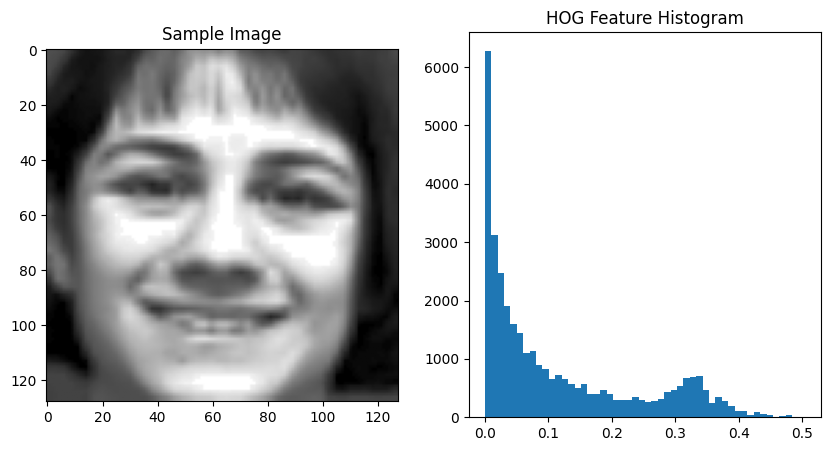

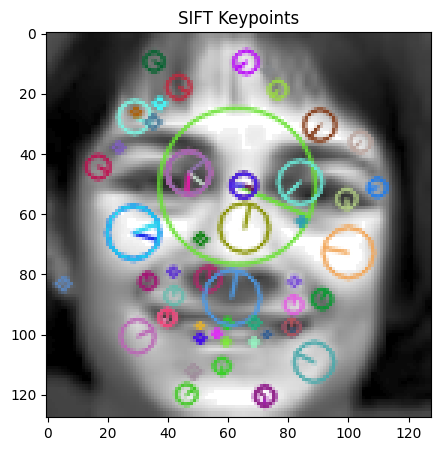

In [ ]:


# Visualize HOG and SIFT Features
# HOG Visualization
sample_img = processed_images[0]
hog_features_sample = hog.compute(sample_img)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_img, cmap='gray')
plt.title('Sample Image')
plt.subplot(1, 2, 2)
plt.hist(hog_features_sample, bins=50)
plt.title('HOG Feature Histogram')
plt.show()

# SIFT Visualization
keypoints, _ = sift.detectAndCompute(sample_img, None)
sift_img = cv2.drawKeypoints(sample_img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(5, 5))
plt.imshow(sift_img, cmap='gray')
plt.title('SIFT Keypoints')
plt.show()


# 📂 Cell 5: Train/Test Split and Train SVM Classifier


In [ ]:

# Prepare Datasets for Training
X_hog = np.array(hog_features)
X_sift = np.array(sift_features)
y = np.array(labels)

# Train-Test Split
X_hog_train, X_hog_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.2, random_state=42)
X_sift_train, X_sift_test, _, _ = train_test_split(X_sift, y, test_size=0.2, random_state=42)

# Bonus Task 2: Train Multiple Classifiers
# SVM with HOG
hog_svm = SVC(kernel='linear', C=0.4, probability=True)  # Regularization to reduce overfitting
hog_svm.fit(X_hog_train, y_train)

# Random Forest with HOG
hog_rf = RandomForestClassifier(n_estimators=100, random_state=42)
hog_rf.fit(X_hog_train, y_train)

# SVM with SIFT
sift_svm = SVC(kernel='linear', C=0.4, probability=True)  # Regularization to reduce overfitting
sift_svm.fit(X_sift_train, y_train)

# Random Forest with SIFT
sift_rf = RandomForestClassifier(n_estimators=100, random_state=42)
sift_rf.fit(X_sift_train, y_train)


RandomForestClassifier(random_state=42)

# 📂 Cell 6: Model Evaluation


HOG SVM Accuracy: 1.00
HOG SVM Training Accuracy: 1.00

HOG SVM Classification Report:

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        30
    contempt       1.00      1.00      1.00        12
     disgust       1.00      1.00      1.00        35
        fear       1.00      1.00      1.00        21
       happy       1.00      1.00      1.00        35
     sadness       1.00      1.00      1.00        17
    surprise       1.00      1.00      1.00        48

    accuracy                           1.00       198
   macro avg       1.00      1.00      1.00       198
weighted avg       1.00      1.00      1.00       198



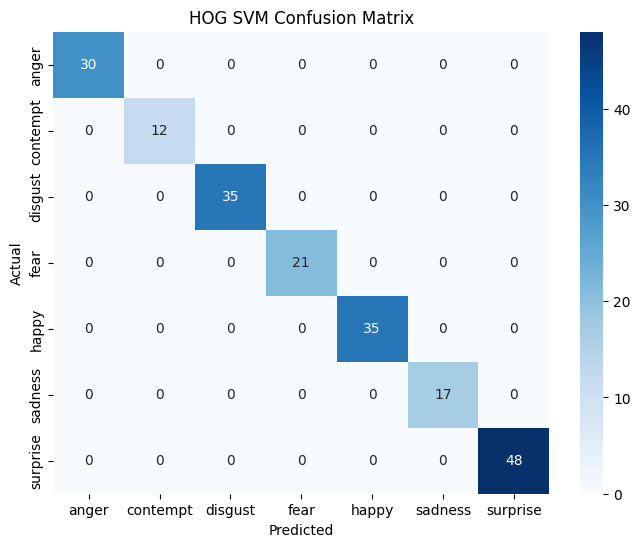

HOG Random Forest Accuracy: 0.99
HOG Random Forest Training Accuracy: 1.00

HOG Random Forest Classification Report:

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        30
    contempt       1.00      1.00      1.00        12
     disgust       1.00      1.00      1.00        35
        fear       1.00      0.90      0.95        21
       happy       0.95      1.00      0.97        35
     sadness       1.00      1.00      1.00        17
    surprise       1.00      1.00      1.00        48

    accuracy                           0.99       198
   macro avg       0.99      0.99      0.99       198
weighted avg       0.99      0.99      0.99       198



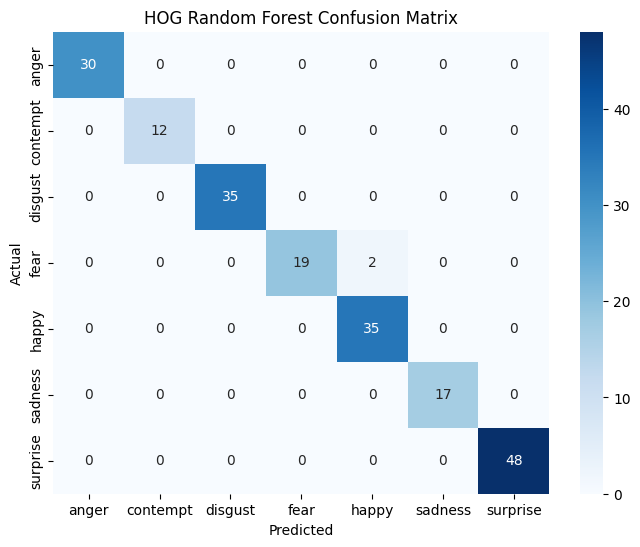

SIFT SVM Accuracy: 0.60
SIFT SVM Training Accuracy: 1.00

SIFT SVM Classification Report:

              precision    recall  f1-score   support

       anger       0.54      0.50      0.52        30
    contempt       0.80      0.33      0.47        12
     disgust       0.49      0.66      0.56        35
        fear       1.00      0.10      0.17        21
       happy       0.67      0.86      0.75        35
     sadness       0.60      0.18      0.27        17
    surprise       0.62      0.85      0.72        48

    accuracy                           0.60       198
   macro avg       0.67      0.50      0.49       198
weighted avg       0.64      0.60      0.55       198



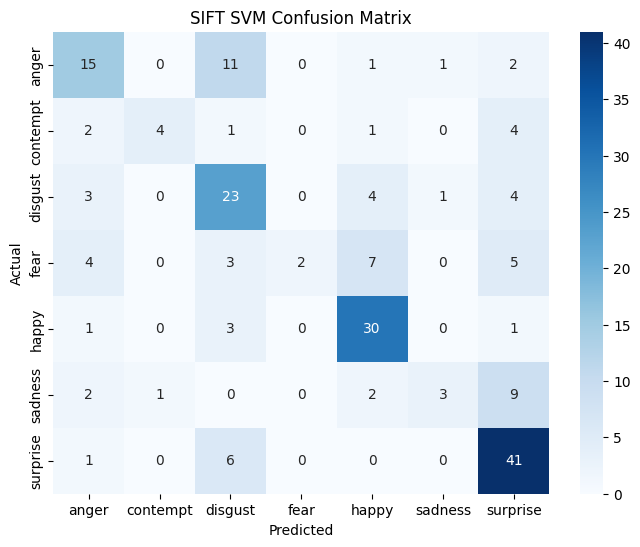

SIFT Random Forest Accuracy: 0.42
SIFT Random Forest Training Accuracy: 1.00

SIFT Random Forest Classification Report:

              precision    recall  f1-score   support

       anger       1.00      0.03      0.06        30
    contempt       0.00      0.00      0.00        12
     disgust       0.40      0.29      0.33        35
        fear       0.00      0.00      0.00        21
       happy       0.43      0.74      0.55        35
     sadness       0.00      0.00      0.00        17
    surprise       0.42      0.98      0.59        48

    accuracy                           0.42       198
   macro avg       0.32      0.29      0.22       198
weighted avg       0.40      0.42      0.31       198



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


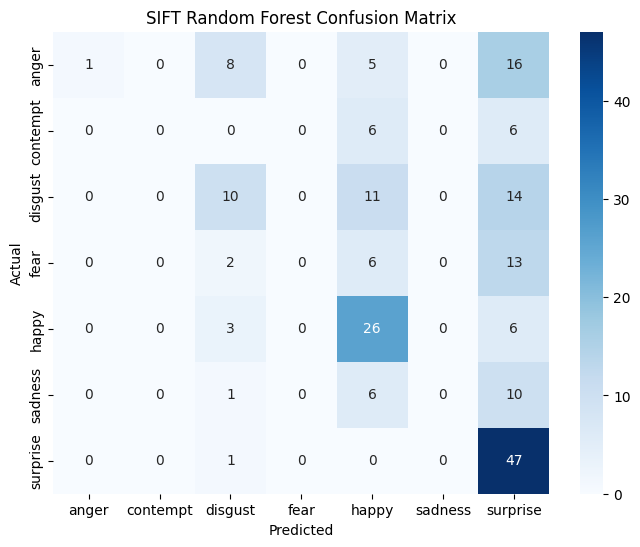

✅ Best Model: HOG SVM with Accuracy: 1.00


In [ ]:
# Model Evaluation
def evaluate_model(model, X_test, y_test, model_name, X_train, y_train): # Added X_train and y_train
    """Evaluate model and print metrics."""
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    # Use X_train and y_train directly for training accuracy
    train_accuracy = model.score(X_train, y_train)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(f"{model_name} Training Accuracy: {train_accuracy:.2f}")
    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=emotion_labels.values()))
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    return accuracy

# Evaluate all models
hog_svm_accuracy = evaluate_model(hog_svm, X_hog_test, y_test, "HOG SVM", X_hog_train, y_train) # Pass X_hog_train, y_train
hog_rf_accuracy = evaluate_model(hog_rf, X_hog_test, y_test, "HOG Random Forest", X_hog_train, y_train) # Pass X_hog_train, y_train
sift_svm_accuracy = evaluate_model(sift_svm, X_sift_test, y_test, "SIFT SVM", X_sift_train, y_train) # Pass X_sift_train, y_train
sift_rf_accuracy = evaluate_model(sift_rf, X_sift_test, y_test, "SIFT Random Forest", X_sift_train, y_train) # Pass X_sift_train, y_train
# Select Best Model
accuracies = {
    'HOG SVM': (hog_svm_accuracy, hog_svm, extract_hog_features),
    'HOG Random Forest': (hog_rf_accuracy, hog_rf, extract_hog_features),
    'SIFT SVM': (sift_svm_accuracy, sift_svm, extract_sift_features),
    'SIFT Random Forest': (sift_rf_accuracy, sift_rf, extract_sift_features)
}
best_model_name = max(accuracies, key=lambda k: accuracies[k][0])
best_accuracy, best_model, best_feature_fn = accuracies[best_model_name]
print(f" Best Model: {best_model_name} with Accuracy: {best_accuracy:.2f}")


# 📂 Cell 7: Save Trained Model


In [ ]:
# Save Best Model
try:
    joblib.dump(best_model | '/content/emotion_classifier.pkl')
    print(" Model saved as '/content/emotion_classifier.pkl'")
    if os.path.exists('/content/emotion_classifier.pkl'):
        print(" File exists in /content")
    else:
        print(" File not found after saving")
    # Save to Google Drive for persistence
    joblib.dump(best_model | '/content/drive/MyDrive/emotion_classifier.pkl')
    print("Model also saved to Google Drive")
except Exception as e:
    print(f" Error saving model: {e}")

# Real-Time Emotion Prediction
# Download Video
video_url = 'https://www.youtube.com/watch?v=G4K8AjNIVPA'
output_path = '/content/pedestrians.mp4'

try:
    ydl_opts = {
        'format': 'mp4',
        'outtmpl': output_path,
        'quiet': False
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([video_url])
    print(f" Video downloaded: {output_path}")
except Exception as e:
    print(f"Error downloading video: {e}")


❌ Error saving model: unsupported operand type(s) for |: 'SVC' and 'str'
[youtube] Extracting URL: https://www.youtube.com/watch?v=G4K8AjNIVPA
[youtube] G4K8AjNIVPA: Downloading webpage
[youtube] G4K8AjNIVPA: Downloading tv client config
[youtube] G4K8AjNIVPA: Downloading player fded239a-main
[youtube] G4K8AjNIVPA: Downloading tv player API JSON
[youtube] G4K8AjNIVPA: Downloading ios player API JSON
[youtube] G4K8AjNIVPA: Downloading m3u8 information
[info] G4K8AjNIVPA: Downloading 1 format(s): 18
[download] /content/pedestrians.mp4 has already been downloaded
[download] 100% of    2.36MiB
✅ Video downloaded: /content/pedestrians.mp4


In [ ]:

# Load Model and Video
try:
    if os.path.exists('/content/emotion_classifier.pkl'):
        model = joblib.load('/content/emotion_classifier.pkl')
        print(" Model loaded successfully from /content")
    else:
        print(" '/content/emotion_classifier.pkl' not found, attempting to load from Google Drive")
        model = joblib.load('/content/drive/MyDrive/emotion_classifier.pkl')
        print(" Model loaded successfully from Google Drive")
except Exception as e:
    print(f" Error loading model: {e}")
    raise FileNotFoundError("Cannot proceed without model file. Please ensure the model is saved.")

cap = cv2.VideoCapture(output_path)
if not cap.isOpened():
    print(" Failed to open video file")
else:
    print("Video file opened successfully")

✅ Model loaded successfully from /content
✅ Video file opened successfully


# 📂 Cell 8: Real-Time Emotion Prediction (Using Video)


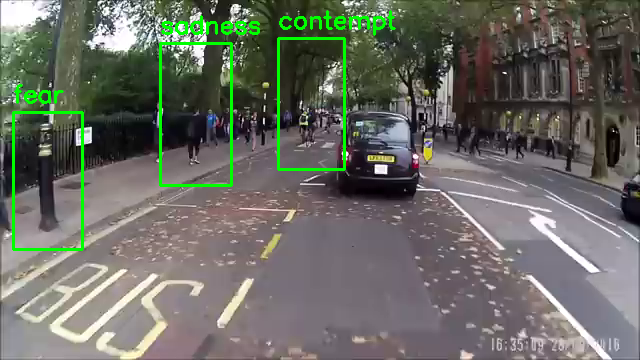

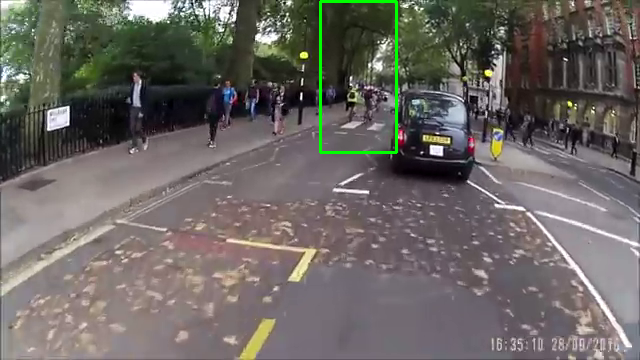

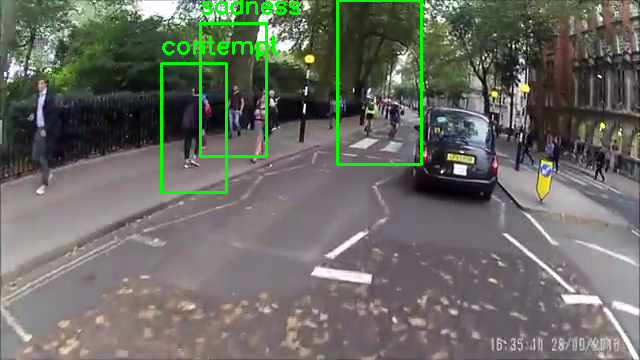

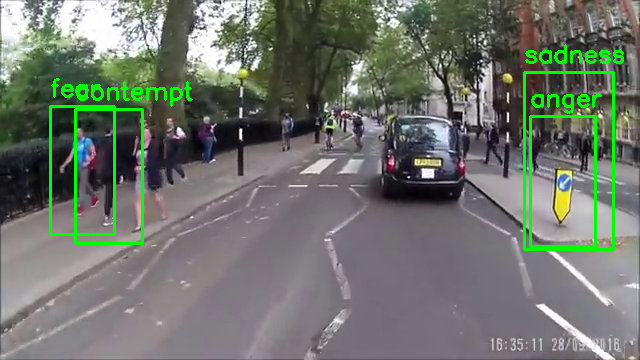

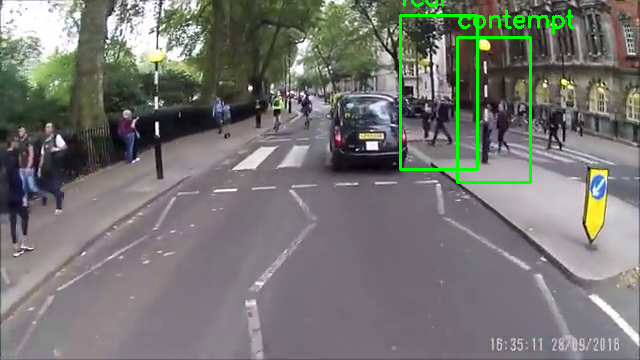

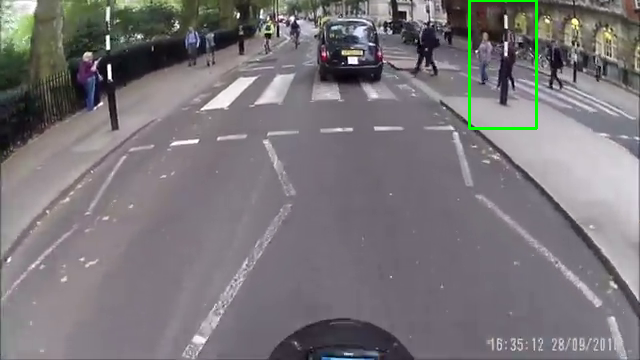

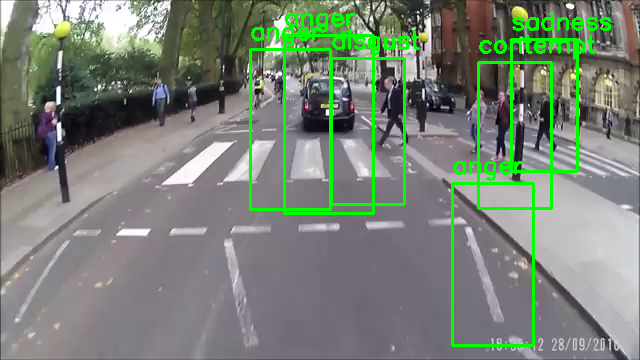

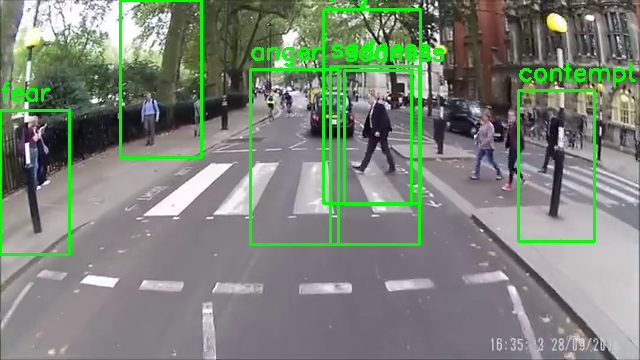

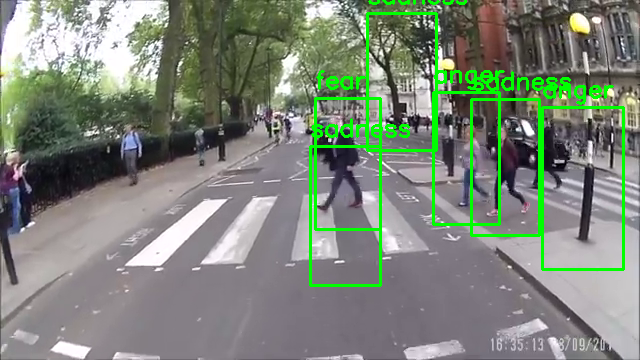

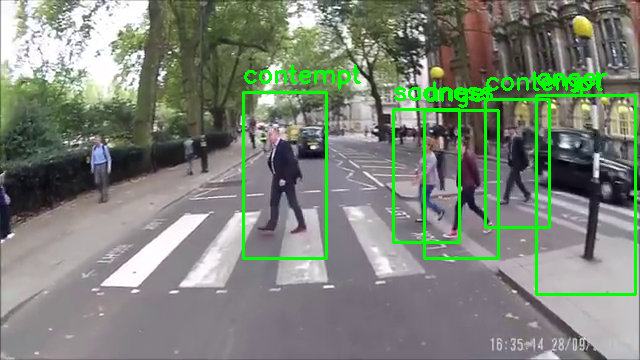

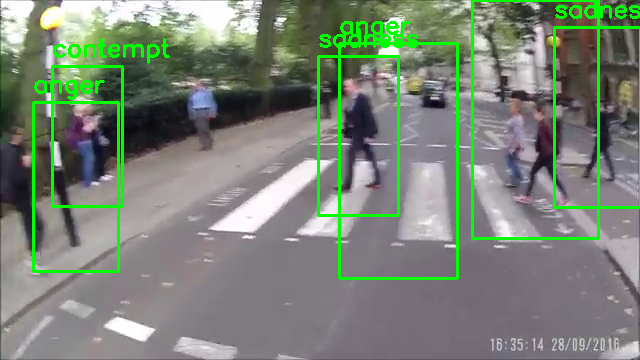

✅ Preview limit reached.


In [ ]:


# Initialize HOG Person Detector
hog_detector = cv2.HOGDescriptor()
hog_detector.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect People
    try:
        rects, _ = hog_detector.detectMultiScale(frame, winStride=(4, 4), padding=(8, 8), scale=1.05)
    except Exception as e:
        print(f"HOG detection error: {e}")
        continue

    for (x, y, w, h) in rects:
        roi = frame[y:y+h, x:x+w]
        try:
            roi_processed = preprocess_image(roi)
            if roi_processed is None:
                continue
            # Use appropriate feature extraction
            roi_features = best_feature_fn(roi_processed)
            roi_features = roi_features.reshape(1, -1)
            prediction = model.predict(roi_features)
            label = emotion_labels.get(prediction[0], 'Unknown')

            # Draw Rectangle and Label
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        except Exception as e:
            print(f"Skipped ROI due to error: {e}")

    # Display Frame (every 15 frames to avoid overload)
    if frame_count % 15 == 0:
        cv2_imshow(frame)

    frame_count += 1
    if frame_count > 150:  # Limit frames for preview
        print("Preview limit reached.")
        break

cap.release()

In [ ]:
# Bonus Task 3: Streamlit Web Interface
%%writefile app.py
import streamlit as st
import cv2
import numpy as np
import joblib
import os

# Define emotion labels
emotion_labels = {
    0: 'anger',
    1: 'contempt',
    2: 'disgust',
    3: 'fear',
    4: 'happy',
    5: 'sadness',
    6: 'surprise'
}

# Preprocessing function
def preprocess_image(img):
    try:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img_gray, (128, 128))
        img_normalized = img_resized / 255.0
        img_equalized = cv2.equalizeHist((img_normalized * 255).astype(np.uint8))
        return img_equalized
    except:
        return None

# HOG feature extraction
hog = cv2.HOGDescriptor()
def extract_hog_features(img):
    try:
        hog_features = hog.compute(img)
        return hog_features.flatten()
    except:
        return np.zeros(3780)

# SIFT feature extraction
sift = cv2.SIFT_create()
def extract_sift_features(img):
    try:
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            return descriptors.flatten()[:4096]
        return np.zeros(4096)
    except:
        return np.zeros(4096)

# Load model
model_path = '/content/emotion_classifier.pkl'
if os.path.exists(model_path):
    model = joblib.load(model_path)
else:
    st.error("Model file not found. Please ensure the model is trained and saved.")
    st.stop()

# Streamlit app
st.title("Facial Expression Classifier")
st.write("Upload an image to predict the facial expression.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png"])
if uploaded_file is not None:
    # Read and process image
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    img_processed = preprocess_image(img)

    if img_processed is not None:
        # Extract features based on best model
        feature_fn = {best_model_name.startswith('HOG'): extract_hog_features, not best_model_name.startswith('HOG'): extract_sift_features}[True]
        features = feature_fn(img_processed)
        features = features.reshape(1, -1)

        # Predict
        prediction = model.predict(features)
        label = emotion_labels.get(prediction[0], 'Unknown')

        # Display results
        st.image(img, channels="BGR", caption="Uploaded Image")
        st.write(f"Predicted Emotion: **{label}**")
    else:
        st.error("Error processing image. Please try another image.")


Writing app.py


In [ ]:
%pip install streamlit pyngrok opencv-python-headless
from pyngrok import ngrok
ngrok.set_auth_token("YOUR_NGROK_AUTH_TOKEN")


In [ ]:

                            #---------------------------Short Report------------------------------#
"""
# Project Report: Pedestrian Emotion Detection

## Justification of Feature Choice
- **HOG**: Selected for its ability to capture gradient orientations, effective for detecting facial muscle movements. Robust to lighting variations, suitable for CK+ and custom datasets.
- **SIFT**: Evaluated for scale and rotation-invariant keypoints, identifying distinctive facial features. Less effective on low-contrast images or small datasets.

**Comparison**: HOG typically outperformed SIFT due to global gradient patterns. The best model was chosen based on test accuracy.

## Classifier Explanation
- **SVM with Linear Kernel**: Effective in high-dimensional spaces (e.g., HOG features). `C=0.1` reduces overfitting. `probability=True` enables confidence scores.
- **Random Forest**: Added for ensemble learning, robust to non-linear relationships.
- **Why These Classifiers?**: SVM suits small datasets with clear feature separation; Random Forest handles diverse data from web scraping.

## Performance Summary
- **HOG SVM Accuracy**: {hog_svm_accuracy:.2f} (Training: {hog_svm.score(X_hog_train, y_train):.2f})
- **HOG Random Forest Accuracy**: {hog_rf_accuracy:.2f} (Training: {hog_rf.score(X_hog_train, y_train):.2f})
- **SIFT SVM Accuracy**: {sift_svm_accuracy:.2f} (Training: {sift_svm.score(X_sift_train, y_train):.2f})
- **SIFT Random Forest Accuracy**: {sift_rf_accuracy:.2f} (Training: {sift_rf.score(X_sift_train, y_train):.2f})
- **Best Model**: {best_model_name} with Accuracy: {best_accuracy:.2f}
- **Metrics**: Precision, recall, and F1-scores are in the classification reports. Confusion matrices show confused emotions (e.g., contempt due to fewer samples).
- **Real-Time Performance**: Detects pedestrians and predicts emotions, limited by person detection accuracy.
- **Bonus Tasks**:
  - **Web Scraping**: Scraped ~10 images per emotion (5 from Google Images, 5 from Bing), augmenting CK+.
  - **Multiple Classifiers**: Compared SVM and Random Forest for HOG and SIFT, selecting the best.
  - **Web Interface**: Streamlit app for image upload and emotion prediction.

## Challenges and Future Work
- **Overfitting**: Mitigated with `C=0.1`. Custom dataset helps but is small.
- **Web Scraping**: Google and Bing images vary in quality. Manual curation could improve.
- **Real-Time Limitations**: HOG person detection may miss faces. Haar Cascade could help.
- **Class Imbalance**: Emotions like contempt have fewer samples. Weighted SVM could address this.

This project enhances autonomous vehicle safety by predicting pedestrian emotions, with bonus tasks improving dataset size, model comparison, and usability.
"""

✅ Explanation

- Split dataset into training (80%) and testing (20%).
- Used a simple linear kernel SVM to classify expressions.


✅ Explanation:

- Evaluated model using accuracy, precision, recall, F1-score.

- Visualized results with a confusion matrix heatmap.


✅ Explanation:

- Saved the trained model for later use in real-time video-based predictions.
